# Predicting Gentrification in Los Angeles

## Using machine learning to more accurately predict which areas of Los Angeles will likely gentrify in the upcoming years

Predicting gentrification is not only useful for businesses that are looking to invest in real estate. It can also help state legislatures make decisions and implement laws that curb displacement and protect communities.

UCLA's Urban Displacement Project has recently published extensive research on gentrification within Los Angeles and other cities. After analyzing huge amounts of data on the populations in neighborhoods around the city (e.g median household income, percent of people living below the poverty line, etc.), the Urban Displacement Project labeled neighborhoods as gentrified or not and assessed the risk that they might gentrify in the future. 

However, the majority of neighborhoods that the project identified as likely to gentrify in 2013 did not show signs of gentrification in 2015.

#### Here I use a supervised random forest model to increase the accuracy of gentrification risk assessment from 60% to 93%.  I also predict which neighborhoods are likely to gentrify in the near future based on recently released data from the American Community Survey.

## The Urban Displacement Project Risk Analysis

Using the available data sets from the Urban Displacement Project in 2013 and 2015, we can see how accurate their risk analysis model is.

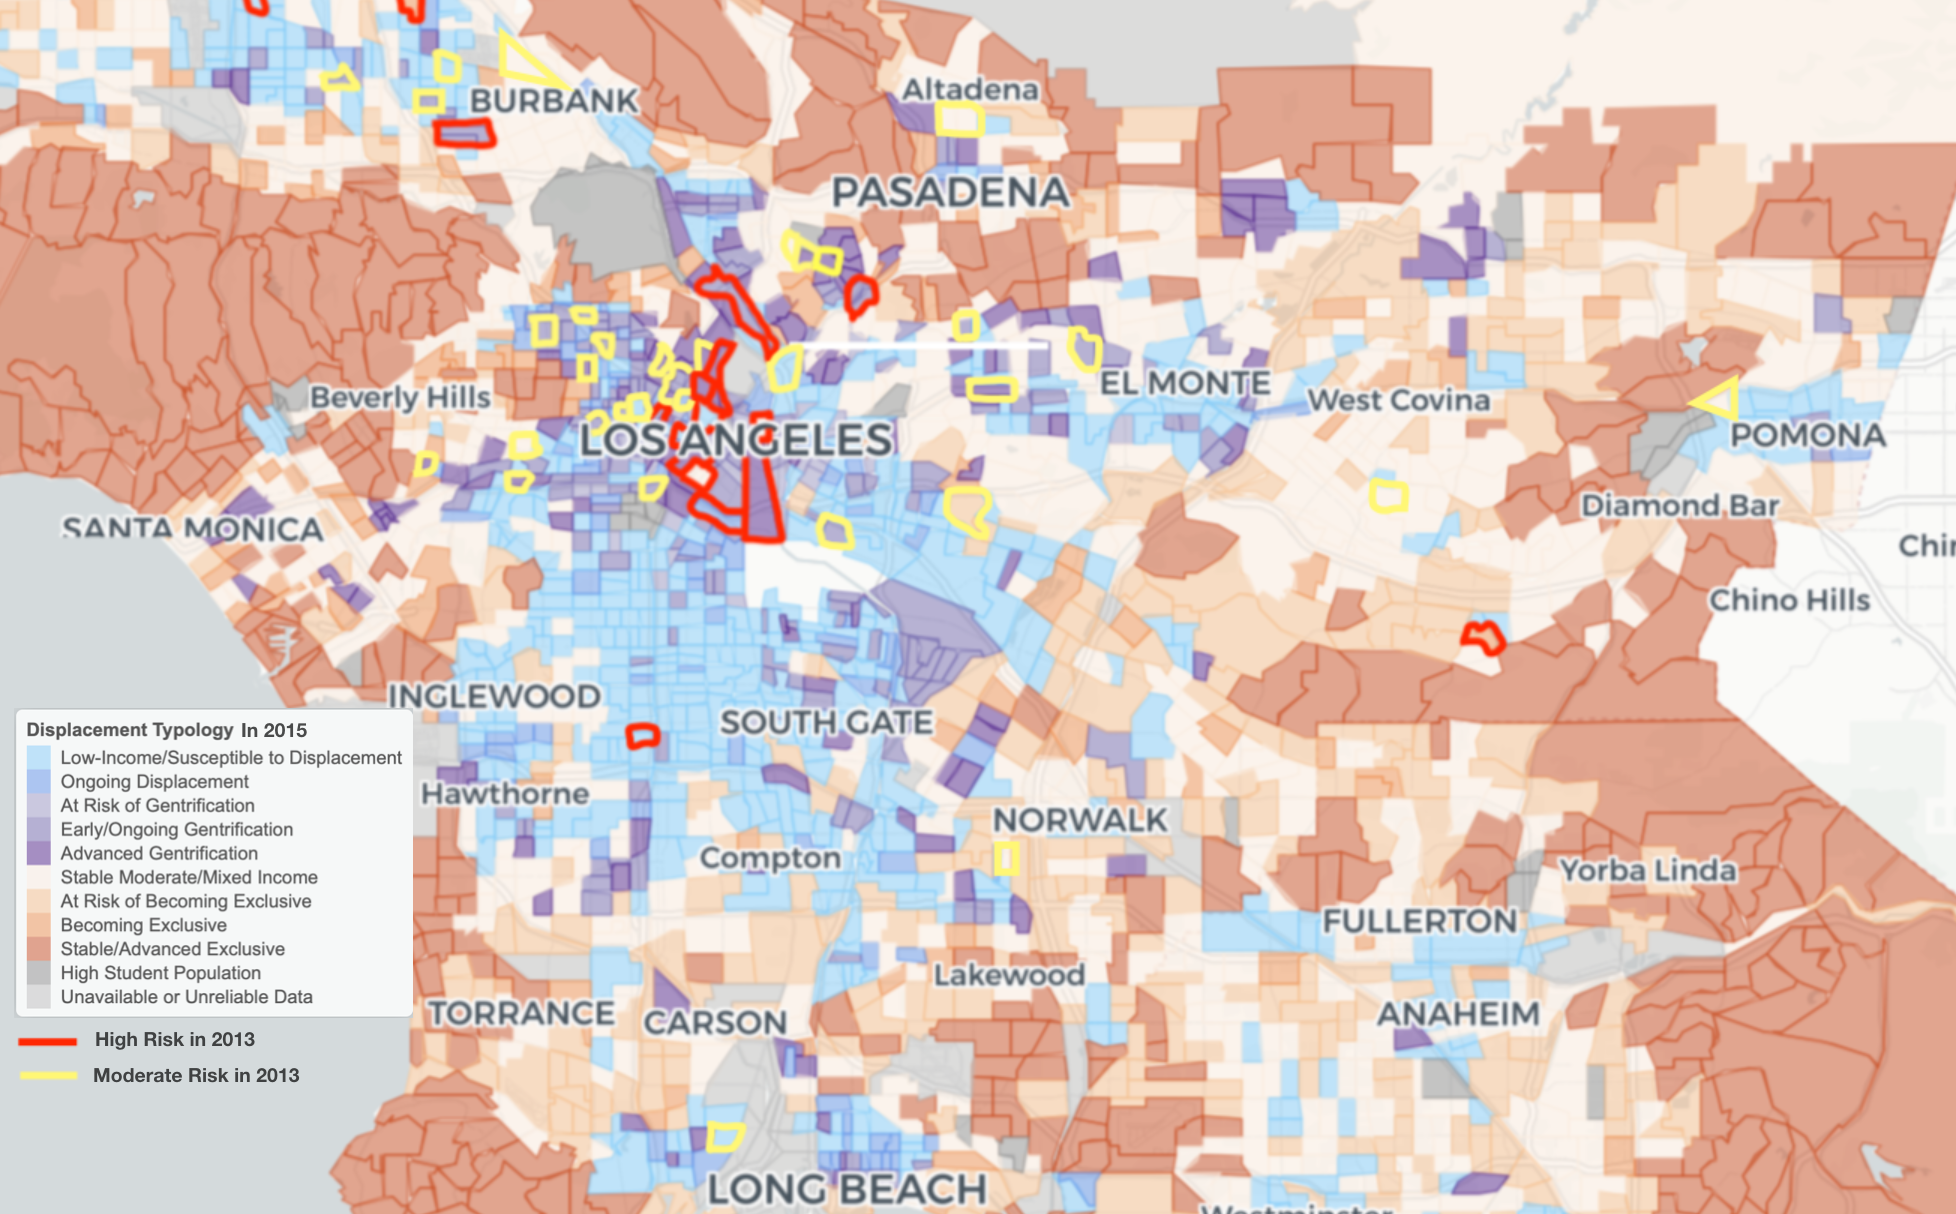

In [2]:
from IPython.display import Image
Image(filename='fullmap.png')

###### Map courtesy of UCLA's Urban Displacement Project

Red and yellow outlines show census tracts identified as at high and moderate risk of gentrifying, respectively, according to data from years up to and including 2013. The underlying map is colored by displacement typology determined with data from years up to and including 2015. As expected, tracts identified as high risk tracts in 2013 are more likely to gentrify in 2015, however, the risk accuracy is ~60% for these areas.

In [1]:
datapath='/Users/lydiaelias/Desktop/Data Science/LA Gentrification Project/Data/'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Load 2013 and 2015 data from Urban Displacement Project

preddata13=pd.read_csv(datapath+'13-lacounty_off-model_tool/Predicted Value-Table 1.csv')
ptractids13=preddata13['TRTID10'].iloc[1:len(preddata13)]
ptractids13=np.array([int(x) for x in ptractids13])

pred13=preddata13['Risk Class'].iloc[1:len(preddata13)]

gentdata15=pd.read_csv(datapath+'ucla_data_7_9_2018/data-Table_1.csv')
tractids15=gentdata15["tract2"]
gentlabs15=gentdata15["gent15"]

#Some of the UDP data is for cities outside LA. We will just focus on those in LA
censustracts=pd.read_csv(datapath+'Census_Tract_Locations__LA_.csv')
tractnums=censustracts["Tract Number"]
tractnumids=np.array([int('6037'+str(x)) for x in tractnums])

#Only chose the tracts for which we have data for both 2013 and 2015 and are in LA
ptractinds13=np.array([np.where(np.array(ptractids13)==x)[0][0] for x in tractnumids if len(np.where(np.array(ptractids13)==x)[0])!=0 ])
tractinds15=np.array([np.where(np.array(tractids15)==x)[0][0] for x in tractnumids if len(np.where(np.array(tractids15)==x)[0])!=0 ])

p13=np.array(pred13)[ptractinds13]
g15=np.array(gentlabs15)[tractinds15]

gentids15=tractids15[tractinds15][np.nonzero(g15)[0]] #The ids of the tracts that were gentrified as of 2015
hiriskids13=ptractids13[np.where(p13==2)[0]] #The ids of the tracts designated 'High Risk' in 2013
modriskids13=ptractids13[np.where(p13==1)[0]] #The ids of the tracts designated 'Moderate Risk' in 2013

print ('# tracts gentrified in 2015=',len(gentids15))
print('# mod. risk tracts that gentrified 2015=',len(gentids15[np.in1d(gentids15,modriskids13)]),'# high risk tracts that gentrified 2015=',len(gentids15[np.in1d(gentids15,hiriskids13)]))
print('% accuracy of mod. risk=',len(gentids15[np.in1d(gentids15,modriskids13)])*100./len(modriskids13),'% accuracy of high risk=',len(gentids15[np.in1d(gentids15,hiriskids13)])*100./len(hiriskids13))

# tracts gentrified in 2015= 91
# mod. risk tracts that gentrified 2015= 17 # high risk tracts that gentrified 2015= 17
% accuracy of mod. risk= 38.63636363636363 % accuracy of high risk= 60.714285714285715


Out of 91 tracts that gentrified as of 2015,  34 were previously flagged; 17 as moderate risk and 17 as high risk. 

#### To assess risk, the UDP uses a very simple analytical model resulting in at most 60% accuracy. Let's see if we can do better with machine learning.

## Data Aquisition from the American Community Survey

The American Community Survey 5-year Census will be the source of data for this project. The 5-year census contains data at the census tract level, where a census tract is roughly the size of a neighborhood.

In [10]:
import requests
import json

## Feature selection

Inspired by the research of the UDP group, I have chosen 5 features to use in my model: population density, median household income, median gross rent, fraction of the adult population below the poverty line, and fraction of the adult population with a bachelor's degree of higher. The UDP uses some other features in their model, including race and percent of renters, which I omit for simplicity's sake and to avoid features correlating with one another.

By restricting the model to these 5 features, I may be missing other important factors that could accurately predict gentrification (e.g proximity to other gentrified tracts, housing prices etc.). Including additional features could greatly improve the accuracy of the model. However, locating data at the census tract level over the past decade can be challenging. For this reason, I stick to five which can be easily extracted from the same survey.

The code below scrapes the html of the ACS site using an API key and processes it with json. I then calculate the  five features in each year of interest for all census tracts and store them.

In [ ]:
sqmis=gentdata15["sqmi"]
halfids15=np.array([str(x)[4:10] for x in tractids15])

#2008 had no data and 2009 had incomplete data so earliest year we can draw from is 2010

year=2016

#Keys are different for 2010 than for later years

tab_2010='B15002_001E,B15002_015E,B15002_016E,B15002_017E,B15002_018E,B15002_032E,B15002_033E,B15002_034E,B15002_035E,B06012_001E,B06012_002E,B25064_001E,B19013_001E,B01001_001E'
tab_2013='B15003_001E,B15003_022E,B15003_023E,B15003_024E,B15003_025E,B17001_001E,B17001_002E,B25064_001E,B19013_001E,B01001_001E'
tab_2016=tab_2013

#B15003_001E is total people age 25 or older whose educational attainment is known (B15002_001E)
#B15003_022E,B15003_023E,B15003_024E,B15003_025E are all added to get total population of adults with a bachelors degree or higher (B15002_015E,B15002_016E,B15002_017E,B15002_018E,B15002_032E,B15002_033E,B15002_034E,B15002_035E)
#B17001_001E is total people whose poverty status in the past 12 months is known (B06012_001E)
#B17001_002E is number of above people whose income is below the poverty line (B06012_002E)
#B25064_001E is median gross rent (B25064_001E)
#B19013_001E is median household income in the past 12 months (B19013_001E)
#B10001_001E is total population (B01001_001E)

dataarr=np.zeros((len(halfids15),5))
badids=[]

#Get data for LA tracts (from 0-2342 in the UDP 2015 table)
for i in range(2342):
    
    tractnum=halfids15[i]
    url = 'https://api.census.gov/data/'+str(year)+'/acs/acs5?get=NAME,'+tab_2016+'&for=tract:'+tractnum+'&in=state:06%20county:037&key=d6ea4a97b91ce5d6489e6107f686bbda72d46713'
    
    page = requests.get(url)
    pagetext = page.text
    
    if len(pagetext)==0:
        
        #Account for when data is not available for some tracts
        badids.append([i,tractnum]) 
    
    else:
        
        data=json.loads(pagetext)
        data=data[1]
    
        totcoll=int(data[1])
        
        #For 2013
        popcoll=int(data[2])+int(data[3])+int(data[4])+int(data[5])    
        povpop=int(data[6])   
        pov=int(data[7])
        medrent=int(data[8])
        medhinc=int(data[9])
        pop=int(data[10])
        
        #For 2010    
        #popcoll=int(data[2])+int(data[3])+int(data[4])+int(data[5])+int(data[6])+int(data[7])+int(data[8])+int(data[9])
        #povpop=int(data[10])
        #pov=int(data[11])
        #medrent=int(data[12])
        #medhinc=int(data[13])
        #pop=int(data[14])
       
        #Sometimes data is available for some features and not others
        if totcoll==0 or povpop==0:
            
            badids.append([i,tractnum]) 
            
        else:
            percoll=popcoll/totcoll
    
            tractarea=sqmis[i]
            popdens=pop/tractarea
    
            dataarr[i][0]=percoll
            dataarr[i][1]=pov/povpop
            dataarr[i][2]=medrent
            dataarr[i][3]=medhinc
            dataarr[i][4]=popdens

np.save(datapath+'la_dataarr_'+str(year),dataarr)
np.save(datapath+'badids_'+str(year),badids)  

## Data trends

Let's take a look at our data.

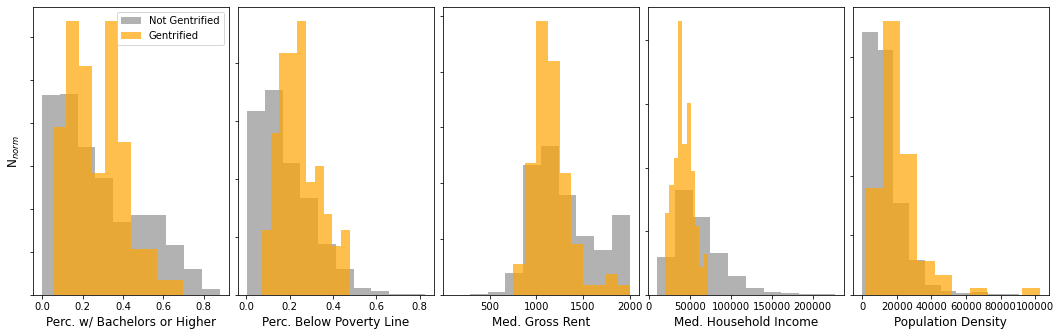

In [3]:
gentids15=np.array(gentdata15["gent15"]).astype(int)

datarr_13=np.load(datapath+'la_dataarr_2013.npy')
datarr_10=np.load(datapath+'la_dataarr_2010.npy')

badids_13=np.load(datapath+'badids_2013.npy')[:,0].astype(int)
badids_10=np.load(datapath+'badids_2010.npy')[:,0].astype(int)

#Account for missing values, which are replaced with -666666666.0 in the survey data. No correlation with the devil is detected.
missids_13=np.concatenate((np.where(datarr_13[:,2]==-666666666.0)[0],np.where(datarr_13[:,3]==-666666666.0)[0]))
missids_10=np.concatenate((np.where(datarr_10[:,2]==-666666666.0)[0],np.where(datarr_10[:,3]==-666666666.0)[0]))

goodids=np.array([x for x in range(2342) if x not in np.concatenate((badids_13,badids_10,missids_13,missids_10))])

#Inspired by previous research into gentrification, we will input the difference between our 2013 and 2010 features into the model
#By looking at the change between years, we can better detect neighborhoods that are going through a rapid shift

features=datarr_13[goodids]-datarr_10[goodids]
labels=gentids15[goodids]

datanames=['Perc. w/ Bachelors or Higher','Perc. Below Poverty Line','Med. Gross Rent','Med. Household Income','Population Density']

f,ax=plt.subplots(1,5,figsize=(15,5))

for i in range(5):
    ax[i].hist(datarr_13[goodids][:,i][np.where(labels==0)[0]],color='k',alpha=0.3,density=True,label='Not Gentrified')
    ax[i].hist(datarr_13[goodids][:,i][np.where(labels==1)[0]],color='orange',alpha=0.7,density=True,label='Gentrified')
    ax[i].set_xlabel(datanames[i],fontsize=12)
    ax[i].set_yticklabels([])
ax[0].set_ylabel('N$_{norm}$',fontsize=12)
ax[0].legend()

plt.subplots_adjust(left = 0.05, right = 0.99, bottom = 0.1,top = 0.9,wspace = 0.05,hspace = 0.1)
plt.show()

Gentrified census tracts have consistently lower percentage of people with a bachelor's degree or higher, higher percentage of people living below the poverty line, lower median gross rent, lower household income, and higher population density. Our results may be counterintuitive, as gentrified neighborhoods are typically thought of as already wealthy. Since gentrification is determined by the UDP by analyzing the percent change from 2000 compared to that of the county, poorer neighborhoods are not precluded from being 'gentrified'. In fact, our results indicate that they are more likely to experience rapid growth associated with gentrification. Neighborhoods that are wealthy but with a stagnant rate of change will also fall into the 'Not Gentrified' group, biasing that group higher.

## SMOTE

In [4]:
print('Fraction of census tracts that are gentrified=',len(np.nonzero(labels)[0]),'/',len(labels))

Fraction of census tracts that are gentrified= 88 / 2278


With only 88 out of 2315 tracts gentrified, our model will suffer from the minority class being too small, making it difficult for the model to accurately predict gentrification.

To avoid this issue, we can use SMOTE to oversample the minority class (basically create artificial gentrified tracts) in the training set

In [36]:
from imblearn.over_sampling import SMOTE
from sklearn import model_selection

oversample=SMOTE(sampling_strategy=0.25) #Only increase minority class to 25% of total (even at this level, we are increasing the number of minority points in the training set six-fold)

#Split into a training and a testing set
train_rf,test_rf,train_rf_labs,test_rf_labs=model_selection.train_test_split(features,labels,test_size=0.4)

train_rf_smote,train_rf_labs_smote=oversample.fit_resample(train_rf,train_rf_labs)

print('Before #Gentrified,#Non-gentrified = ',[len(np.nonzero(train_rf_labs)[0]),len(train_rf_labs)])
print('After #Gentrified,#Non-gentrified = ',[len(np.nonzero(train_rf_labs_smote)[0]),len(train_rf_labs_smote)])

Before #Gentrified,#Non-gentrified =  [52, 1366]
After #Gentrified,#Non-gentrified =  [328, 1642]


So we have added ~275 artifical gentrified tracts

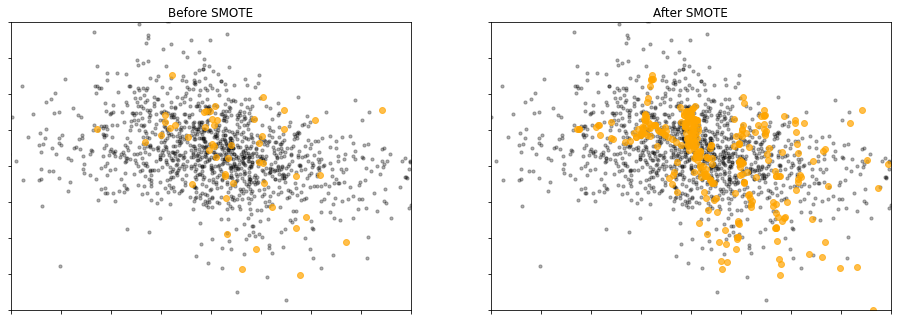

In [37]:
f,ax=plt.subplots(1,2,figsize=(13,5))

nzids=np.nonzero(train_rf_labs)[0]
zids=np.where(train_rf_labs==0)[0]

ax[0].scatter(train_rf[:,3][zids],train_rf[:,1][zids],s=10,alpha=0.3,c='k')
ax[0].scatter(train_rf[:,3][nzids],train_rf[:,1][nzids],c='orange',alpha=0.7)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_title('Before SMOTE')
ax[0].set_xlim([-2.e4,2.e4])
ax[0].set_ylim([-0.2,0.2])

nzids=np.nonzero(train_rf_labs_smote)[0]
zids=np.where(train_rf_labs_smote==0)[0]

ax[1].scatter(train_rf_smote[:,3][zids],train_rf_smote[:,1][zids],s=10,alpha=0.3,c='k')
ax[1].scatter(train_rf_smote[:,3][nzids],train_rf_smote[:,1][nzids],c='orange',alpha=0.7)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title('After SMOTE')
ax[1].set_xlim([-2.e4,2.e4])
ax[1].set_ylim([-0.2,0.2])

plt.subplots_adjust(left = 0.05, right = 0.99, bottom = 0.1,top = 0.9,wspace = 0.2,hspace = 0.2)
plt.show()

## Training and Testing the Model

We are now ready to train our model. We use a random forest classifier as it is a simple and reliable option for classification problems.

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 200)

#Fit the model on the training set and predict
rf.fit(train_rf_smote,train_rf_labs_smote)
predprobs_rf = rf.predict_proba(test_rf)

## Feature importances

In [59]:
df = pd.DataFrame(columns=datanames)
df.loc[0]=rf.feature_importances_
print(df)

   Perc. w/ Bachelors or Higher  Perc. Below Poverty Line  Med. Gross Rent  \
0                      0.175127                  0.173087         0.165136   

   Med. Household Income  Population Density  
0               0.215427            0.271224  


All features probed have approximately equal importance with population density being slightly more important than other features. Some of these features (e.g perc. below poverty line and med. household income) are correlated. Therefore we expect the feature importance to be reduced even if the feature they both represent (money) is relatively important.

The model has outputted the probability that each census tract will gentrify in the next couple years. To analyze the accuracy of the model, we can try several probability thresholds above which a tract is labeled 'gentrified'.

## Bias - variance tradeoff

It's important, especially with a small minority class and use of SMOTE, to make sure that our model isn't learning the noise in the training set. For a random forest model, we are mostly worried about a high variance.

In [63]:
from mlxtend.evaluate import bias_variance_decomp

rf_1 = RandomForestClassifier(n_estimators = 200)

mse, bias, var = bias_variance_decomp(rf_1, train_rf_smote, train_rf_labs_smote, test_rf, test_rf_labs, loss='mse', num_rounds=200, random_seed=1)
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.067
Bias: 0.053
Variance: 0.014


It looks like neither bias nor variance is a problem in our model. With a larger dataset I would split into a cross-validation set and observe the error in the model as I increase the size of the training set. However, with only 88 datapoints in the minority class, a cross-validation set would have very little to validate on.

### Let's take a look at a couple metrics: precision and recall

Instead of just looking at percent accuracy, we can look at some more nuanced metrics: precision and recall. Since the fraction of data belonging to the minority class is so small, we choose these metrics as opposed to AUC ROC and f1.

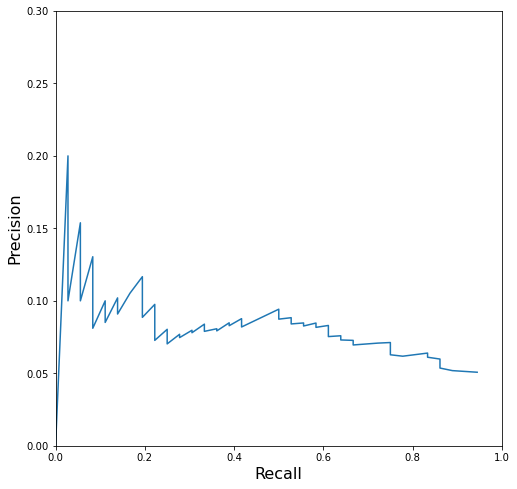

In [51]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

precs=[]
recs=[]

for i in np.linspace(0.01,0.75,300):
    p_thresh=i
    predlabs_rf=np.array([1 if x>p_thresh else 0 for x in predprobs_rf[:,1]])

    tn, fp, fn, tp = confusion_matrix(test_rf_labs,predlabs_rf).ravel()
    
    prec=np.float(tp)/(tp+fp)
    rec=np.float(tp)/(tp+fn)
    precs.append(prec)
    recs.append(rec)
    
f,ax=plt.subplots(1,figsize=(8,8))
s=16

ax.plot(recs,precs)
#ax.plot([0,1],[0,1],linestyle='--')
ax.set_xlabel('Recall',fontsize=s)
ax.set_ylabel('Precision',fontsize=s)
ax.set_xlim([0,1])
ax.set_ylim([0,0.3])

plt.show()

In the case of real estate investment, we may choose to be more cautious by minimizing false positives and therefore maximizing precision. However, for the case of instituting laws we may want to minimize false negatives and maximize recall. I will choose a threshold of 0.4 to give a reasonable value of both while erring on the side of caution.

In [64]:
p_thresh=0.4
predlabs_rf=np.array([1 if x>p_thresh else 0 for x in predprobs_rf[:,1]])

tn, fp, fn, tp = confusion_matrix(test_rf_labs,predlabs_rf).ravel()
acc=(tp+tn)/len(test_rf_labs)


print('% accuracy at 0.4 probability threshold=',acc)

% accuracy at 0.4 probability threshold= 0.9199561403508771


## At this probability threshold, we have achieved an accuracy of ~92%, an improvement in accuracy of ~30%

This means the model has learned to predict gentrification as it is defined by the UDP.  A caveat to this result is how well the UDP definition of gentrification maps to other real-world data and definitions. Future analysis might also include other features that are known to correlate with gentrification e.g proximity to other gentrified neighborhoods, access to public transportation, etc.

## We can now apply the same model to data from the American Community Survey in 2016 and 2019 and make a prediction for census tracts that are set to gentrify in the upcoming year

In [52]:
datarr_19=np.load(datapath+'la_dataarr_2019.npy')
datarr_16=np.load(datapath+'la_dataarr_2016.npy')

badids_19=np.load(datapath+'badids_2019.npy')[:,0].astype(int)
badids_16=np.load(datapath+'badids_2016.npy')[:,0].astype(int)

#Account for missing values
missids_19=np.concatenate((np.where(datarr_19[:,2]==-666666666.0)[0],np.where(datarr_19[:,3]==-666666666.0)[0]))
missids_16=np.concatenate((np.where(datarr_16[:,2]==-666666666.0)[0],np.where(datarr_16[:,3]==-666666666.0)[0]))

nanids_19=np.where(np.isnan(datarr_19))[0]
nanids_16=np.where(np.isnan(datarr_16))[0]

goodids_new=np.array([x for x in range(2342) if x not in np.concatenate((badids_19,badids_16,missids_19,missids_16,nanids_19,nanids_16))])

features_new=datarr_19[goodids_new]-datarr_16[goodids_new]

In [53]:
predprobs_rf_new = rf.predict_proba(features_new)

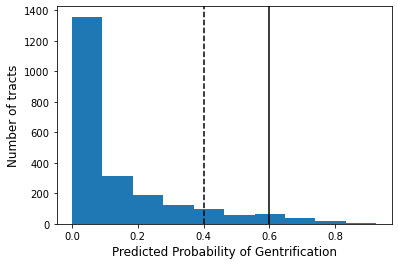

Number of gentrified tracts for p_thresh=0.4= 242
Number of gentrified tracts for p_thresh=0.6= 96


In [56]:
plt.figure()
plt.hist(predprobs_rf_new[:,1])
plt.axvline(x=0.4,color='k',linestyle='--')
plt.axvline(x=0.6,color='k')
plt.xlabel('Predicted Probability of Gentrification',fontsize=12)
plt.ylabel('Number of tracts',fontsize=12)
plt.show()

print('Number of gentrified tracts for p_thresh=0.4=',len(np.where(predprobs_rf_new[:,1]>0.4)[0]))
print('Number of gentrified tracts for p_thresh=0.6=',len(np.where(predprobs_rf_new[:,1]>0.6)[0]))

If we use the same probability threshold of 40% as before, we predict that 242 census tracts will gentrify in the near future. This may be overzealous given previous data. To be safer, we can increase the probability threshold to 60%, such that we predict 96 census tracts will be gentrified in the upcoming year, likely decreasing our false positive rate.

In [57]:
pthresh_new=0.6

tractids_new=np.array(tractids15)[0:2342][goodids_new]
gids15_new=tractids_new[np.where(gentids15[goodids_new]>0)[0]] #Ids of tracts gentrified as of 2015
print(len(tractids_new),len(predprobs_rf_new))

gids20=tractids_new[np.where(predprobs_rf_new[:,1]>pthresh_new)[0]] #Ids of tracts predicted to gentrify in 2021

print('Fraction of tracts gentrified in 2015 and 2021=',len(gids15_new[np.in1d(gids15_new,gids20)]),'/',len(gids15_new))

2270 2270
Fraction of tracts gentrified in 2015 and 2021= 4 / 88


So only 4 of the tracts predicted to be gentrified in 2021 were already gentrified in 2015. This may be because features of census tracts that were gentrified by 2015 are no longer changing at an appreciable rate. The rapid pace of gentrification is not completely surprising. According to reports from the UDP, only 42 out of 91 census tracts that were gentrified as of 2015 were also gentrified as of 2013. These 42 tracts had their main increases in median gross rent and percent of college educated adults.

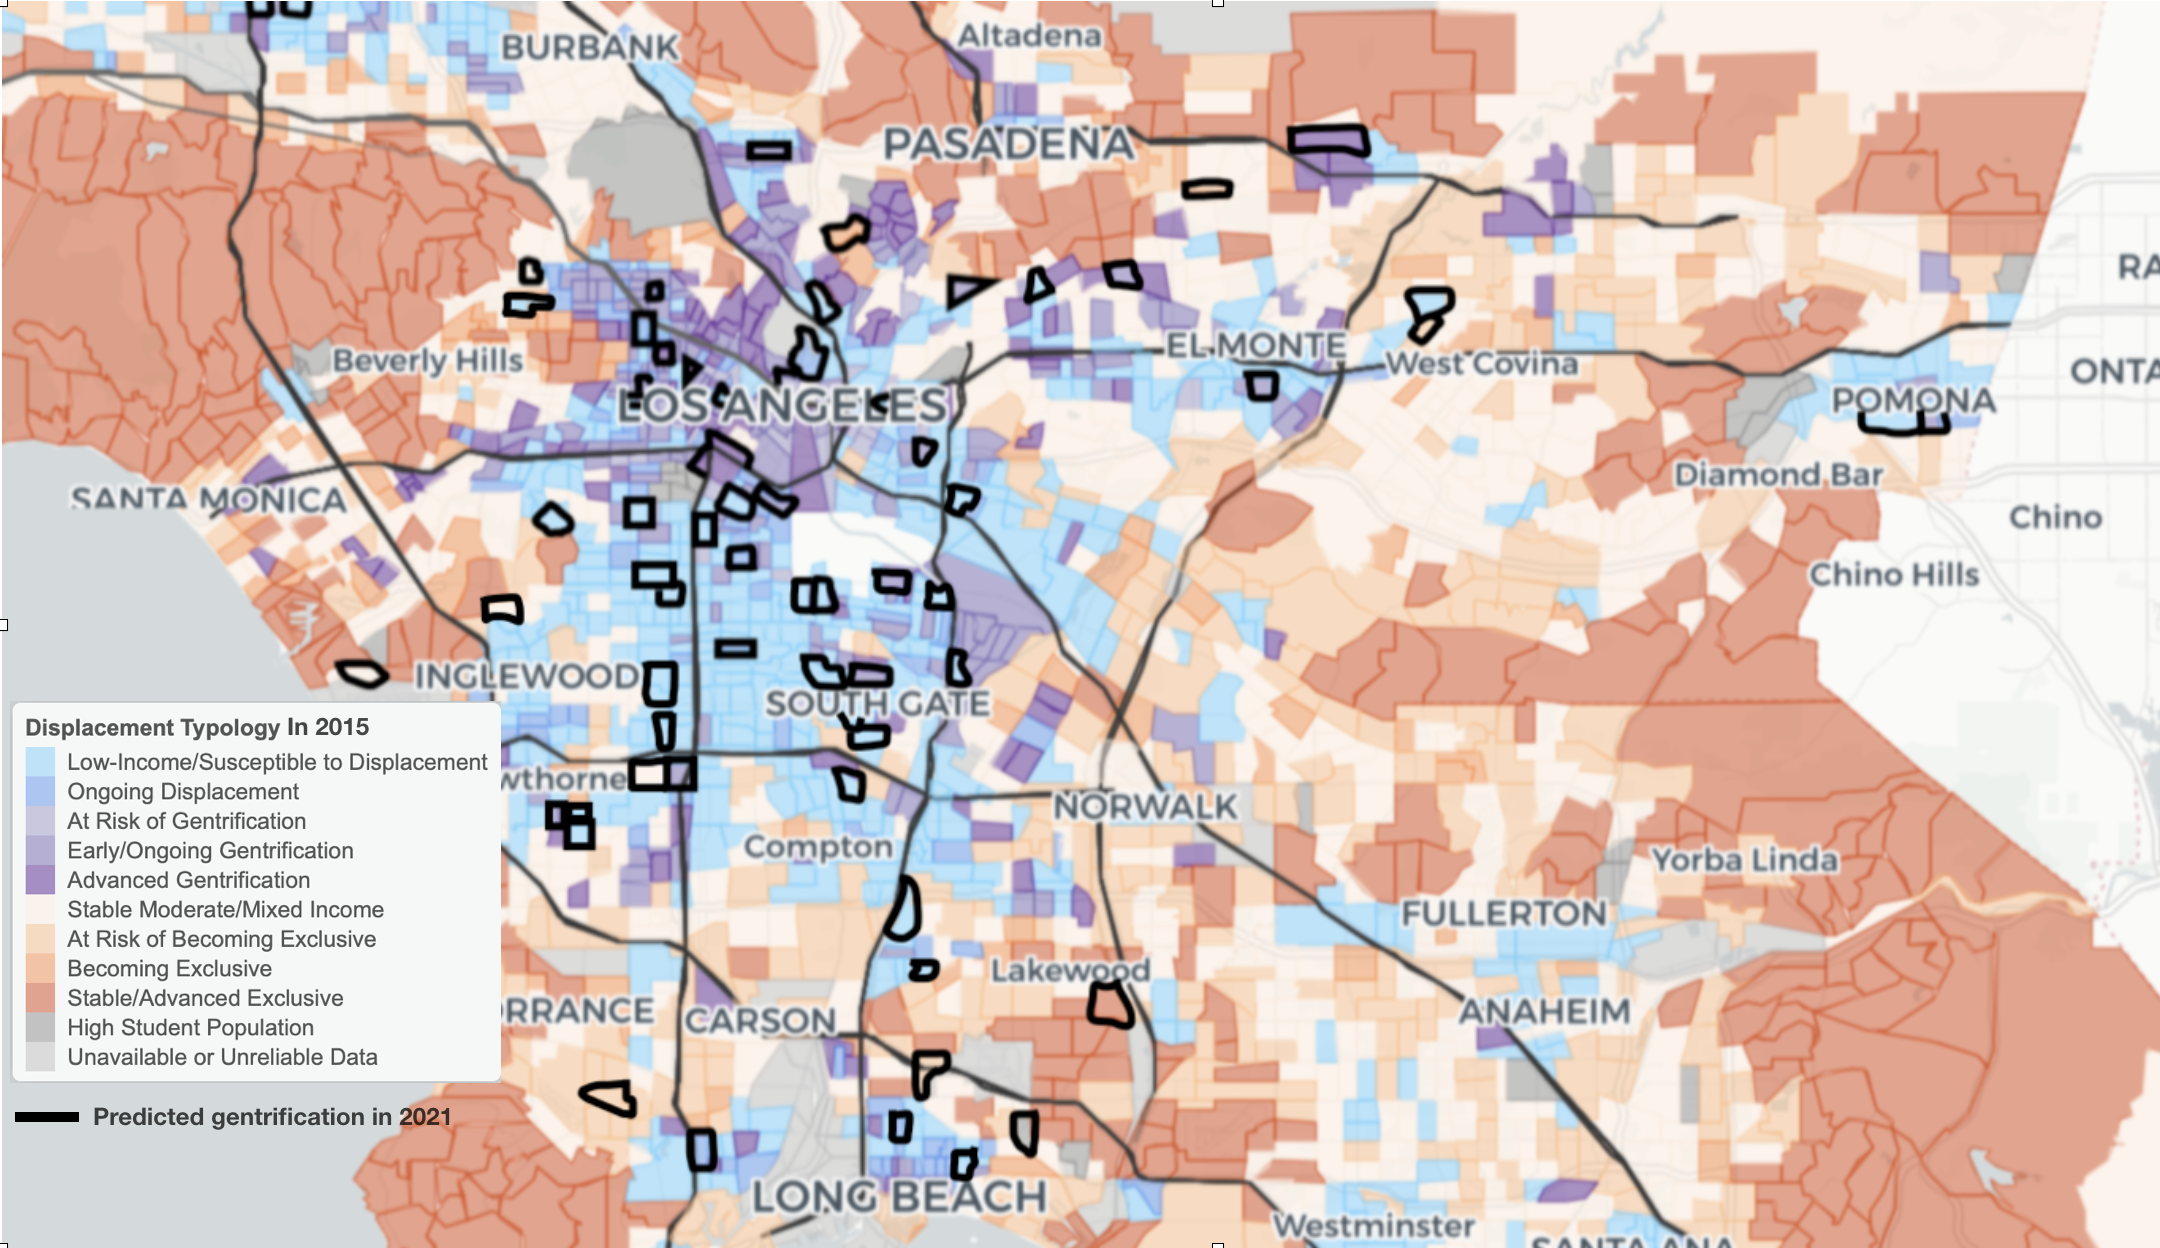

In [134]:
Image(filename='fullmap_2021.png')

Interestingly, the tracts predicted to gentrify are more spread out than those predicted to gentrify in 2013 and 2015. This may be a sign that communities further from downtown Los Angeles, where real estate prices are lower, are becoming more desirable.

Some of the census tracts the model predicts will gentrify are more obvious than others. For example, the Koreatown and Little Tokyo areas are already well known for gentrification. However, other areas where the predicted tracts appear, such as Montebello and Lynnwood, are more surprising.

# Thanks for reading! If you have any questions, feel free to contact me at lydia.elias29@gmail.com. Suggestions for this project and others are always welcome.